## Lib

In [1]:
!pip install -qq Pillow requests numpy
import io
import string
import requests
import zipfile
import numpy as np
import tensorflow as tf
from pathlib import Path
from PIL import Image, ImageFont, ImageDraw
from tensorflow import keras
from keras.utils import img_to_array


GOOGLE_FONTS_URL = "https://github.com/google/fonts/archive/main.zip"
FONTS_DIRECTORY = "./fonts"
IMAGES_DIRECTORY = "./images"
FONT_SIZE = 38
FONT_FG = "#000000"  # black foreground
FONT_BG = "#FFFFFF"  # white background
FONT_PADDING = 4
IMG_WIDTH = 38
IMG_HEIGHT = 38


def get_or_create_directory(path: str):
    path = Path(path).resolve()
    if not path.exists() or not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)
    return path


FONTS_PATH = get_or_create_directory(FONTS_DIRECTORY)
IMAGES_PATH = get_or_create_directory(IMAGES_DIRECTORY)


def download_and_extract_fonts(dest_path=FONTS_PATH):
    content, total = io.BytesIO(), 0
    req = requests.get(GOOGLE_FONTS_URL, stream=True)

    for chunk in req.iter_content(chunk_size=None):
        if chunk:
            content.write(chunk)
            total += len(chunk)
            print(f"Downloading: {total / 1024**2:.2f} MB", end='\r', flush=True)
    print(f"Downloading: done." + " " * 40, flush=True)

    print("Extracting fonts...", end=' ', flush=True)
    zip_file = zipfile.ZipFile(content)
    zip_file.extractall(dest_path)
    print("Done.")

def draw_letter(letter, font):
    font_object = ImageFont.truetype(str(font.resolve()), FONT_SIZE)
    image = Image.new("L", (IMG_WIDTH, IMG_HEIGHT), color=FONT_BG)
    draw_pad = ImageDraw.Draw(image)
    draw_pad.text((IMG_WIDTH / 2, IMG_HEIGHT / 2), text=letter, font=font_object, anchor="mm", align='center', fill=FONT_FG)
    return image

def save_alphabet(font):
    dest_path = get_or_create_directory(IMAGES_PATH / font.stem)

    for low, up in zip(string.ascii_lowercase, string.ascii_uppercase):
        image_low = img_to_array(draw_letter(low, font)) / 255.0
        image_up = img_to_array(draw_letter(up, font)) / 255.0
        np.savez(dest_path / f"{low}{up}.npz", low=image_low, up=image_up)

def process_fonts():
    font_files = set(Path("./fonts").glob("**/*.ttf"))
    for i, font in enumerate(font_files):
        print(f"Processing '{font.stem}'... ({(i/len(font_files))*100:.2f}%)", end=' '*80 + '\r')
        try:
            save_alphabet(font)
        except OSError:
            continue
    print("Done.")

2023-11-07 17:28:10.487149: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Process fonts

In [3]:
#download_and_extract_fonts()

Downloading: done.                                        
Extracting fonts... Done.


In [2]:
!rm -rf images; rm -f /content/*.npz
process_fonts()

Done.ssing 'Fahkwang-SemiBoldItalic'... (99.97%)                                                                                                                                     


## Create dataset

In [2]:
import random
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras


def images_generator(images_dir='/content/images'):
    pairs =sorted(pathlib.Path(images_dir.decode()).glob('*/*.npz'))
    
    for pair in pairs:
        letters = np.load(pair)
        yield letters['low'], letters['up']

        
def get_dataset(source):
    return tf.data.Dataset.from_generator(images_generator, args=[source], output_signature=(
        tf.TensorSpec(shape=(38, 38, 1)), tf.TensorSpec(shape=(38, 38, 1)),
    )).cache().repeat().shuffle(BATCH_SIZE**2, reshuffle_each_iteration=True).batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


BATCH_SIZE = 32
NB_FILES = len(set(pathlib.Path('/content/images').glob('*/*.npz')))
SPE = int(NB_FILES / BATCH_SIZE)
print(f"Batch size: {BATCH_SIZE}\n{NB_FILES} samples\nSPE: {SPE}")

dataset_training = get_dataset(b'/content/images')

Batch size: 32
90532 samples
SPE: 2829


2023-11-07 17:28:12.414880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 17:28:13.015201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43453 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:53:00.0, compute capability: 8.6


## Display dataset

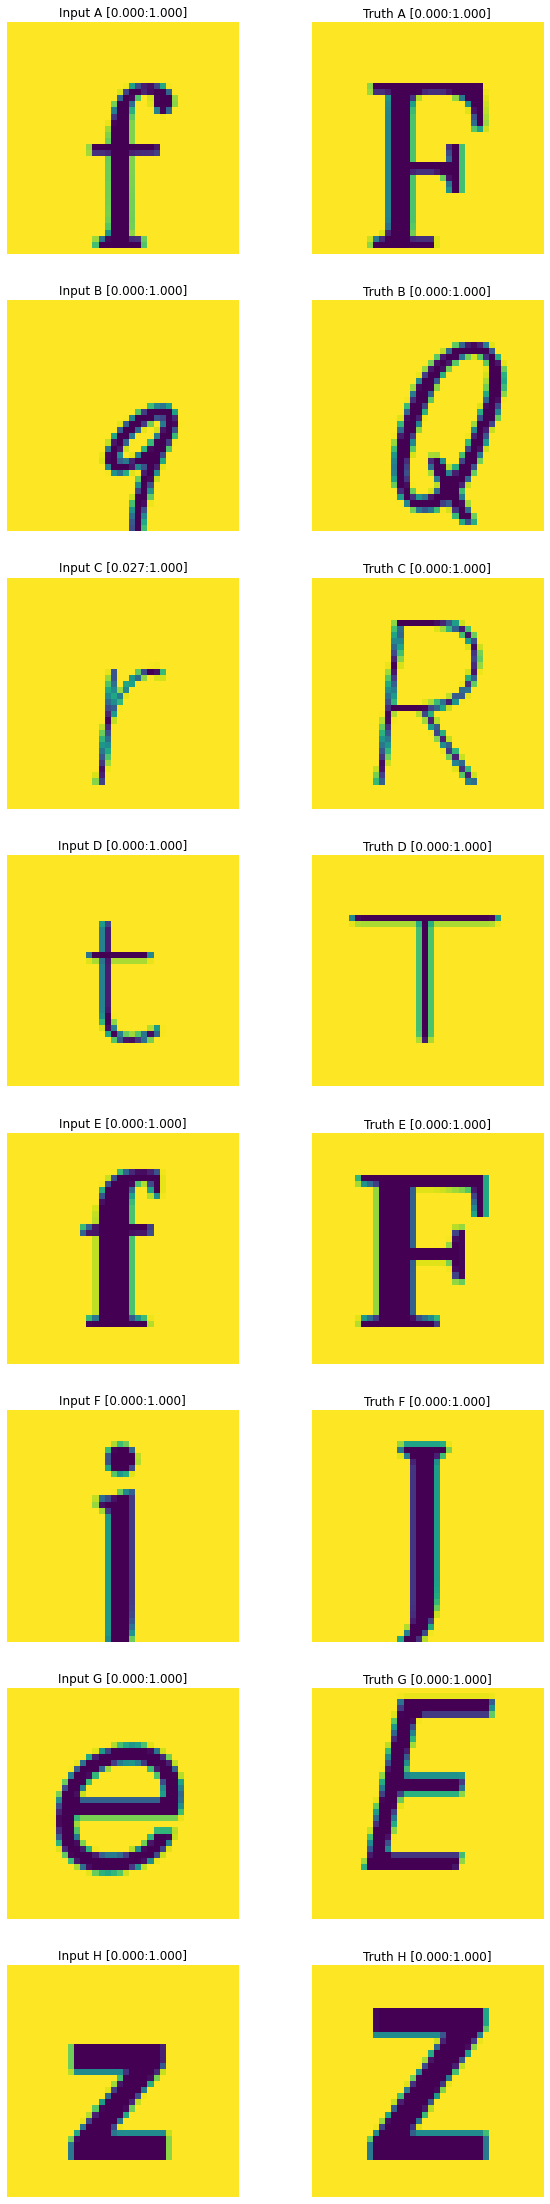

In [5]:
!pip install -qq matplotlib
import string
import numpy as np
from tensorflow import keras
from keras.utils import array_to_img
from matplotlib import pyplot as plt


batch = list(dataset_training.take(1).as_numpy_iterator())
batchX, batchY = batch[0][0], batch[0][1]
choices = zip(range(8), string.ascii_uppercase)

plt.figure(figsize=(2 * 5, 8 * 5))

for i, l in choices:
    x = batchX[i]
    pixmin, pixmax = np.min(x), np.max(x)
    img = array_to_img(x * 255.0, scale=False)
    plt.subplot(8, 2, i*2 + 1)
    plt.imshow(img)
    plt.title(f'Input {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

    y = batchY[i]
    pixmin, pixmax = np.min(y), np.max(y)
    img = array_to_img(y * 255.0, scale=False)
    plt.subplot(8, 2, i*2 + 2)
    plt.imshow(img)
    plt.title(f'Truth {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

## Model

In [3]:
import tempfile
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.constraints import max_norm


xargs = dict(padding='same', kernel_initializer='he_uniform')

model = Sequential([
    layers.Conv2D(128, (3, 3), strides=2, input_shape=(38, 38, 1), **xargs),
    layers.LeakyReLU(),
    
    layers.Conv2D(32, (3, 3), **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    
    layers.Conv2D(8, (3, 3), **xargs),
    layers.LeakyReLU(),
    
    layers.Flatten(),
    layers.Dense(19 * 19 * 8, activation='sigmoid'),
    layers.Dense(19 * 19 * 8, activation='sigmoid'),
    layers.Reshape((19, 19, 8)),
    
    layers.Conv2DTranspose(8, (3, 3), **xargs),
    layers.LeakyReLU(),
    
    layers.Conv2DTranspose(32, (3, 3), **xargs),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    
    layers.Conv2DTranspose(128, (3, 3), strides=2, **xargs),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),
])

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def custom_loss(y_true, y_pred):
    alpha = 0.8
    ssim_loss = (1 - tf.image.ssim(y_true, y_pred, max_val=1.0))
    mae_loss = tf.reduce_mean(tf.abs((y_true) - (y_pred)))
    loss = (alpha * ssim_loss + (1-alpha) * mae_loss)
    return tf.reduce_mean(loss)


model.compile(loss=custom_loss,
              metrics=[keras.losses.MAE, PSNR, SSIM],
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 19, 19, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        36896     
                                                                 
 batch_normalization (BatchN  (None, 19, 19, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 19, 19, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 8)         2312      
                                                        

In [4]:
_, checkpoint_train = tempfile.mkstemp(prefix='training_', suffix='.h5', dir='/tmp')
checkpoint_t = keras.callbacks.ModelCheckpoint(checkpoint_train, monitor='loss', save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)

training = model.fit(dataset_training, epochs=20, steps_per_epoch=SPE, callbacks=(checkpoint_t, early_stop))

Epoch 1/20


2023-11-07 17:28:32.260716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-11-07 17:28:33.681595: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2829/2829 [==============================] - 136s 46ms/step - loss: 0.3161 - mean_absolute_error: 0.0824 - PSNR: 14.6841 - SSIM: 0.6255
Epoch 2/20
2829/2829 [==============================] - 34s 12ms/step - loss: 0.2664 - mean_absolute_error: 0.0695 - PSNR: 15.7528 - SSIM: 0.6843
Epoch 3/20
2829/2829 [==============================] - 34s 12ms/step - loss: 0.2499 - mean_absolute_error: 0.0657 - PSNR: 16.1827 - SSIM: 0.7040
Epoch 4/20
2829/2829 [==============================] - 34s 12ms/step - loss: 0.2373 - mean_absolute_error: 0.0629 - PSNR: 16.5193 - SSIM: 0.7191
Epoch 5/20
2829/2829 [==============================] - 35s 12ms/step - loss: 0.2263 - mean_absolute_error: 0.0605 - PSNR: 16.8116 - SSIM: 0.7323
Epoch 6/20
2829/2829 [==============================] - 33s 12ms/step - loss: 0.2154 - mean_absolute_error: 0.0582 - PSNR: 17.0951 - SSIM: 0.7453
Epoch 7/20
2829/2829 [==============================] - 34s 12ms/step - loss: 0.2042 - mean_absolute_error: 0.0557 - PSNR: 17.4220 - S

1/1 [==============================] - 0s 58ms/step


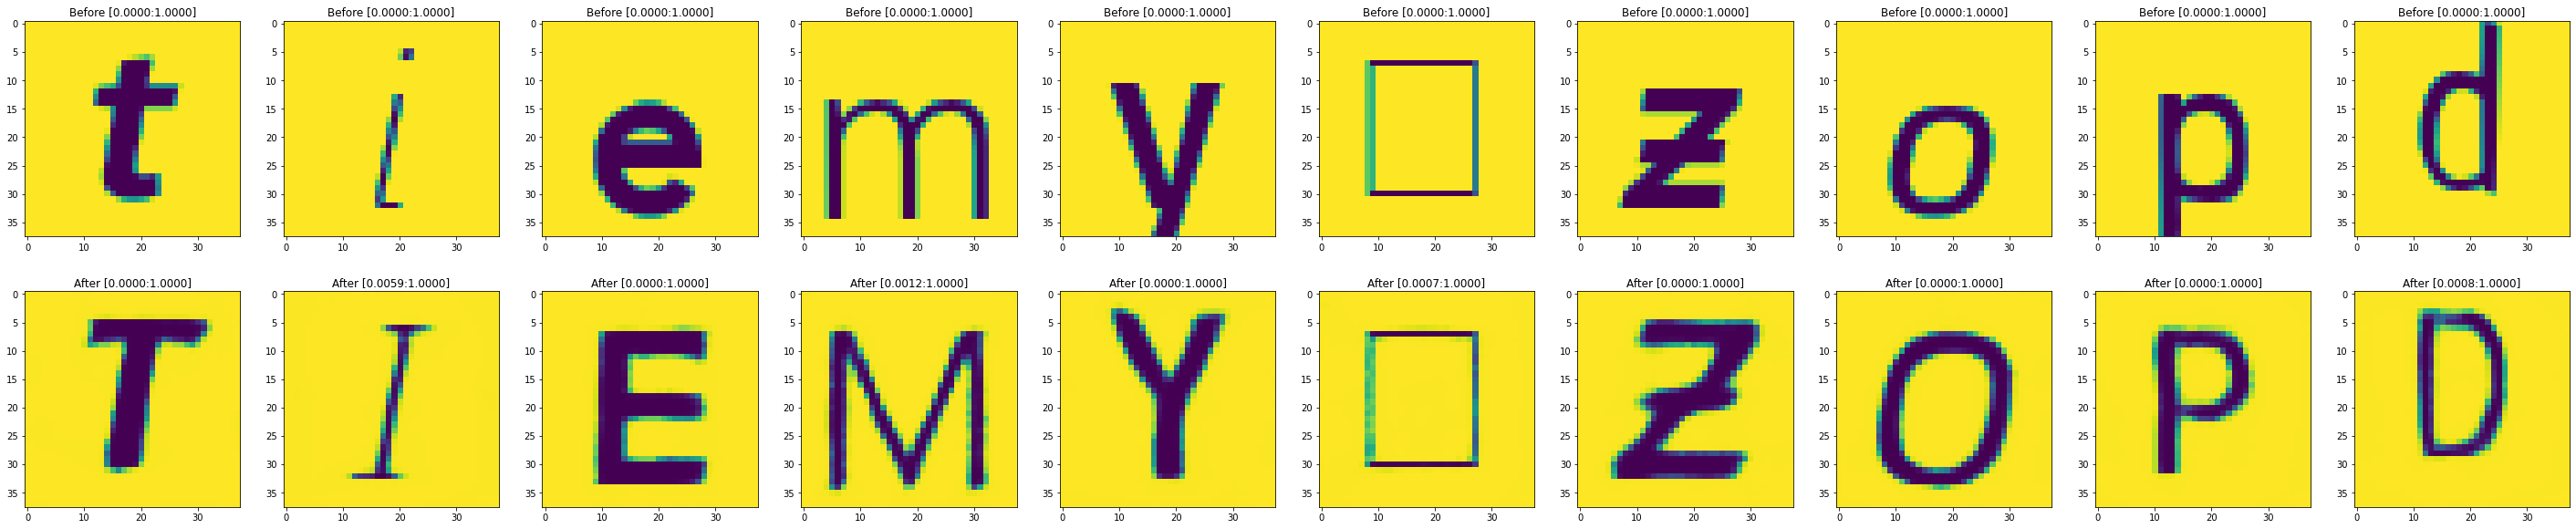

In [5]:
import random
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img
from keras.models import Model


if 'checkpoint_train' in locals() and 'training' not in locals():
    print("Loading weights...")
    model.load_weights(checkpoint_train)

originals = random.sample(sorted(pathlib.Path('/content/images/').resolve().glob('*/*.npz')), 10)
plt.figure(figsize=(50, 10))
i = 0

for original in originals:
    array = np.load(original)['low']

    batch = np.array([array])
    pred = model.predict(batch)

    img_1 = array_to_img(array * 255.0, scale=False)
    img_2 = array_to_img(pred[0] * 255.0, scale=False)

    plt.subplot(2, 10, i + 1)
    plt.imshow(img_1, interpolation=None)
    pixmin, pixmax = np.min(array), np.max(array)
    plt.title(f"Before [{pixmin:.4f}:{pixmax:.4f}]")
    plt.subplot(2, 10, i + 11)
    plt.imshow(img_2, interpolation=None)
    pixmin, pixmax = np.min(pred[0]), np.max(pred[0])
    plt.title(f"After [{pixmin:.4f}:{pixmax:.4f}]")

    i += 1

dict_keys(['loss', 'mean_absolute_error', 'PSNR', 'SSIM'])


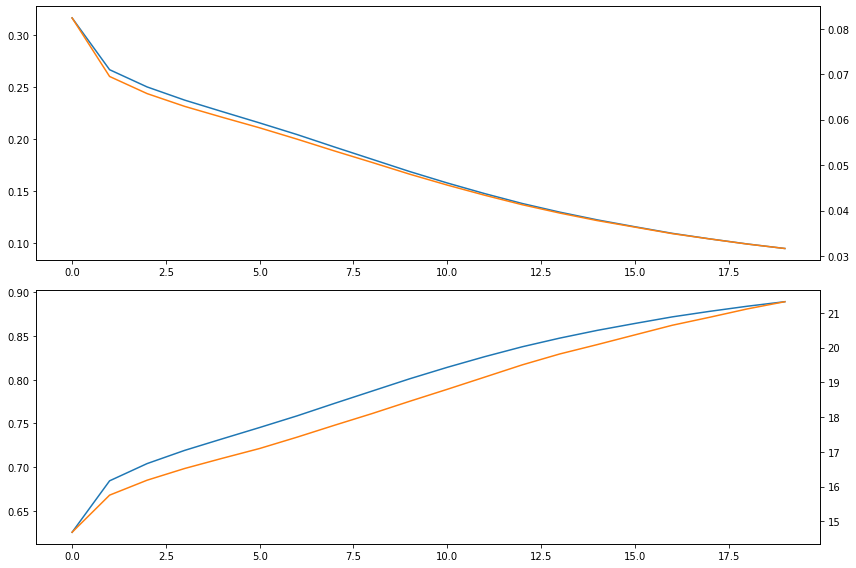

In [8]:
!pip install -qq matplotlib
from matplotlib import pyplot as plt

def plot_performance(history):
    print(history.history.keys())
    loss = history.history['loss']
    ssim = history.history['SSIM']
    psnr = history.history['PSNR']
    mae = history.history['mean_absolute_error']
    
    nb_epochs = len(loss)
    epochs_range = range(nb_epochs)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(epochs_range, loss, label='Loss', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(epochs_range, mae, label='MAE', color='tab:orange')
    
    ax3.plot(epochs_range, ssim, label='SSIM', color='tab:blue')
    ax4 = ax3.twinx()
    ax4.plot(epochs_range, psnr, label='PSNR', color='tab:orange')

    fig.tight_layout()
    plt.show()

plot_performance(training)

In [9]:
model.save('uppestcase.keras')
model.save('uppestcase_weights.h5')